In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cocodataset/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


# # **CNN Classifier On a MNIST Dataset**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [5]:
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 101943229.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49932272.80it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24430613.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7669295.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



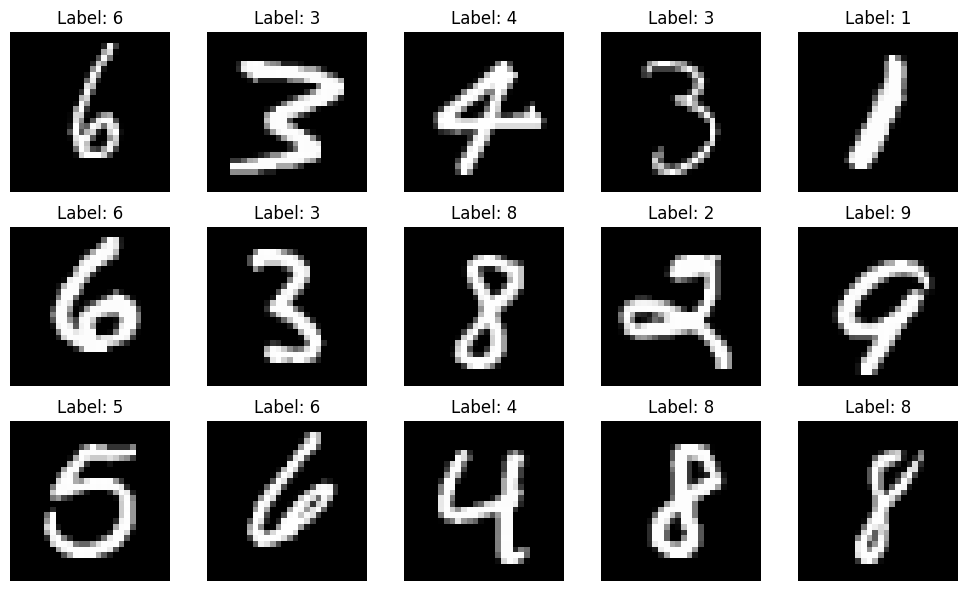

In [6]:
import matplotlib.pyplot as plt

# Define a function to display images
def show_images(images, labels, nrows=3, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display some sample images from the dataset
dataiter=iter(train_loader)
sample_images, sample_labels = next(dataiter)
show_images(sample_images, sample_labels)


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
model = CNN().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 0.2788447259661199
Epoch 2/5, Loss: 0.10119651629478295
Epoch 3/5, Loss: 0.07556928633334938
Epoch 4/5, Loss: 0.06064216884598732
Epoch 5/5, Loss: 0.05072807212611402


In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total}%")

Accuracy on the test set: 99.03%


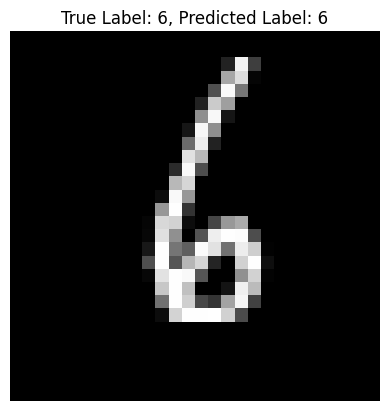

In [12]:
import numpy as np


example_index = 0
# Get the corresponding image and label
example_image = sample_images[example_index]  # Add batch dimension
example_label = sample_labels[example_index]

# Make prediction
model.eval()
with torch.no_grad():
    example_image = example_image.to(device)
    output = model(example_image)
    predicted_label = torch.argmax(output).item()

# Display the example image and prediction
plt.imshow(example_image.squeeze().cpu(), cmap='gray')
plt.title(f"True Label: {example_label}, Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()


# #  **Faster R-CNN On a COCO datasets For object Detection**

In [13]:
!mkdir -p /root/.cache/torch/hub/checkpoints
!cp /kaggle/input/cocodataset/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms
import numpy as np
import struct
from array import array

In [15]:
class FasterRCNNNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(FasterRCNNNet, self).__init__()
        self.faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = self.faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
        self.faster_rcnn_model.roi_heads.box_predictor = nn.Linear(in_features, num_classes)
    def load_pretrained_weights(self, model_path):
        state_dict = torch.load(model_path)
        mapping_dict = {
            "conv1.weight": "backbone.body.conv1.weight",
            "bn1.weight": "backbone.body.bn1.weight",
        }
        adjusted_state_dict = {}
        for key, value in state_dict.items():
            if key in mapping_dict:
                adjusted_key = mapping_dict[key]
                adjusted_state_dict[adjusted_key] = value
        self.faster_rcnn_model.load_state_dict(adjusted_state_dict, strict=False)
    def forward(self, images, targets=None):
        if self.training and targets is not None:
            targets = [{k: v for k, v in target.items()} for target in targets]
            loss_dict = self.faster_rcnn_model(images, targets)
            return sum(loss for loss in loss_dict.values())
        else:
            return self.faster_rcnn_model(images)

In [16]:
class FastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
    def forward(self, x):
        return self.cls_score(x)

In [17]:
import PIL

class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        # Convert list of pixels to PIL image
        image = PIL.Image.fromarray(np.array(image))

        if self.transform:
            image = self.transform(image)

        height, width = image.shape[-2:]
        box = torch.tensor([0, 0, width, height], dtype=torch.float32)

        sample = {
            "images": image,
            "boxes": box,
            "labels": torch.tensor(label, dtype=torch.int64)
        }
        return sample


In [18]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath, transform=None):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
        self.transform = transform
    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img
        return images, labels
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        train_dataset = MnistDataset(x_train, y_train, transform=self.transform)
        test_dataset = MnistDataset(x_test, y_test, transform=self.transform)
        return train_dataset, test_dataset

In [19]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataloader = MnistDataloader(
    '/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
    '/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    '/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
    '/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte',
    transform=transform
)

batch_size = 2
train_dataset, test_dataset = mnist_dataloader.load_data()
mnist_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
mnist_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
num_classes = 10
faster_rcnn_net = FasterRCNNNet(num_classes)
model_path = "/kaggle/input/cocodataset/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
faster_rcnn_net.load_pretrained_weights(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
faster_rcnn_net.to(device)
optimizer = optim.Adam(faster_rcnn_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 161MB/s]


CrossEntropyLoss()

In [21]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        images = batch["images"].to(device)
        boxes = batch["boxes"].to(device)
        labels = batch["labels"].to(device)
        targets = [{"boxes": boxes, "labels": labels}]
        optimizer.zero_grad()
        outputs = model(images, targets)
        loss = sum(outputs.values())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [22]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    return avg_loss, accuracy